In [4]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

# Modelling Sampling effort
The data is taken from the Redis database. 
This mimics the process performed in the cluster or other independent computing infrastructures.

We will use the functions defined in spystats.biospytial_models

In [57]:
import external_plugins.spystats.biospytial_models.runner as bm
import redis
conn = redis.StrictRedis(host='redis',password='biospytial.')
#trainkey = 't-guerrero-p4'
#predkey = 'p-100x100-guerrero-poly4'
trainkey = 't-puebla-p2-abies-pinophyta'
predkey = 'p-100x100-puebla-poly2'

PDF = bm.preparePredictors(bm.loadDataFrameFromRedis(predkey,conn))
TDF = bm.loadDataFrameFromRedis(trainkey,conn)

INFO:external_plugins.spystats.biospytial_models.runner:Loading data from RedisDB
INFO:external_plugins.spystats.biospytial_models.runner:Loading data from RedisDB


In [6]:
## Associate the categorical variables
TDF['name'] = TDF['name'].astype('category')
TDF['wwf_mhtnam'] = TDF['wwf_mhtnam'].astype('category')
TDF['tipos'] = TDF['tipos'].astype('category')

PDF['clean']['name'] = PDF['clean']['name'].astype('category')
PDF['clean']['wwf_mhtnam'] = PDF['clean']['wwf_mhtnam'].astype('category')
PDF['clean']['tipos'] = PDF['clean']['tipos'].astype('category')

PDF['full']['name'] = PDF['full']['name'].astype('category')
PDF['full']['wwf_mhtnam'] = PDF['full']['wwf_mhtnam'].astype('category')
PDF['full']['tipos'] = PDF['full']['tipos'].astype('category')



/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [7]:
formula = 'Pinophyta ~ Longitude + Latitude + Q("Dist.to.road_m") + Population_m + tipos'

In [8]:
TM,PM = bm.splitByFormula(formula,TDF,PDF['clean'])

INFO:external_plugins.spystats.biospytial_models.runner:Creating Design matrices from the formula Pinophyta ~ Longitude + Latitude + Q("Dist.to.road_m") + Population_m + tipos


In [9]:
model,gp = bm.ModelSamplingEffort(TM,PM)

In [ ]:
trace = bm.SampleModel(model,inference_method='mcmc',ncores=3,niters=2000)

INFO:external_plugins.spystats.biospytial_models.runner:Selected inference method: MCMC  n_iters 2000, njobs 3
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [latent_field, phi, sigma, tau, b_tipos[T.ZonaUrbana], b_tipos[T.PraderadeAltaMontana], b_tipos[T.SelvaBajaCaducifolia], b_Latitude, b_tipos[T.PastizalCultivado], b_tipos[T.AreassinVegetacionAparente], b_Intercept, b_tipos[T.MatorralDeserticoRosetofilo], b_Longitude, b_ti

In [18]:
import pymc3 as pm

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e21516950>,
      dtype=object)

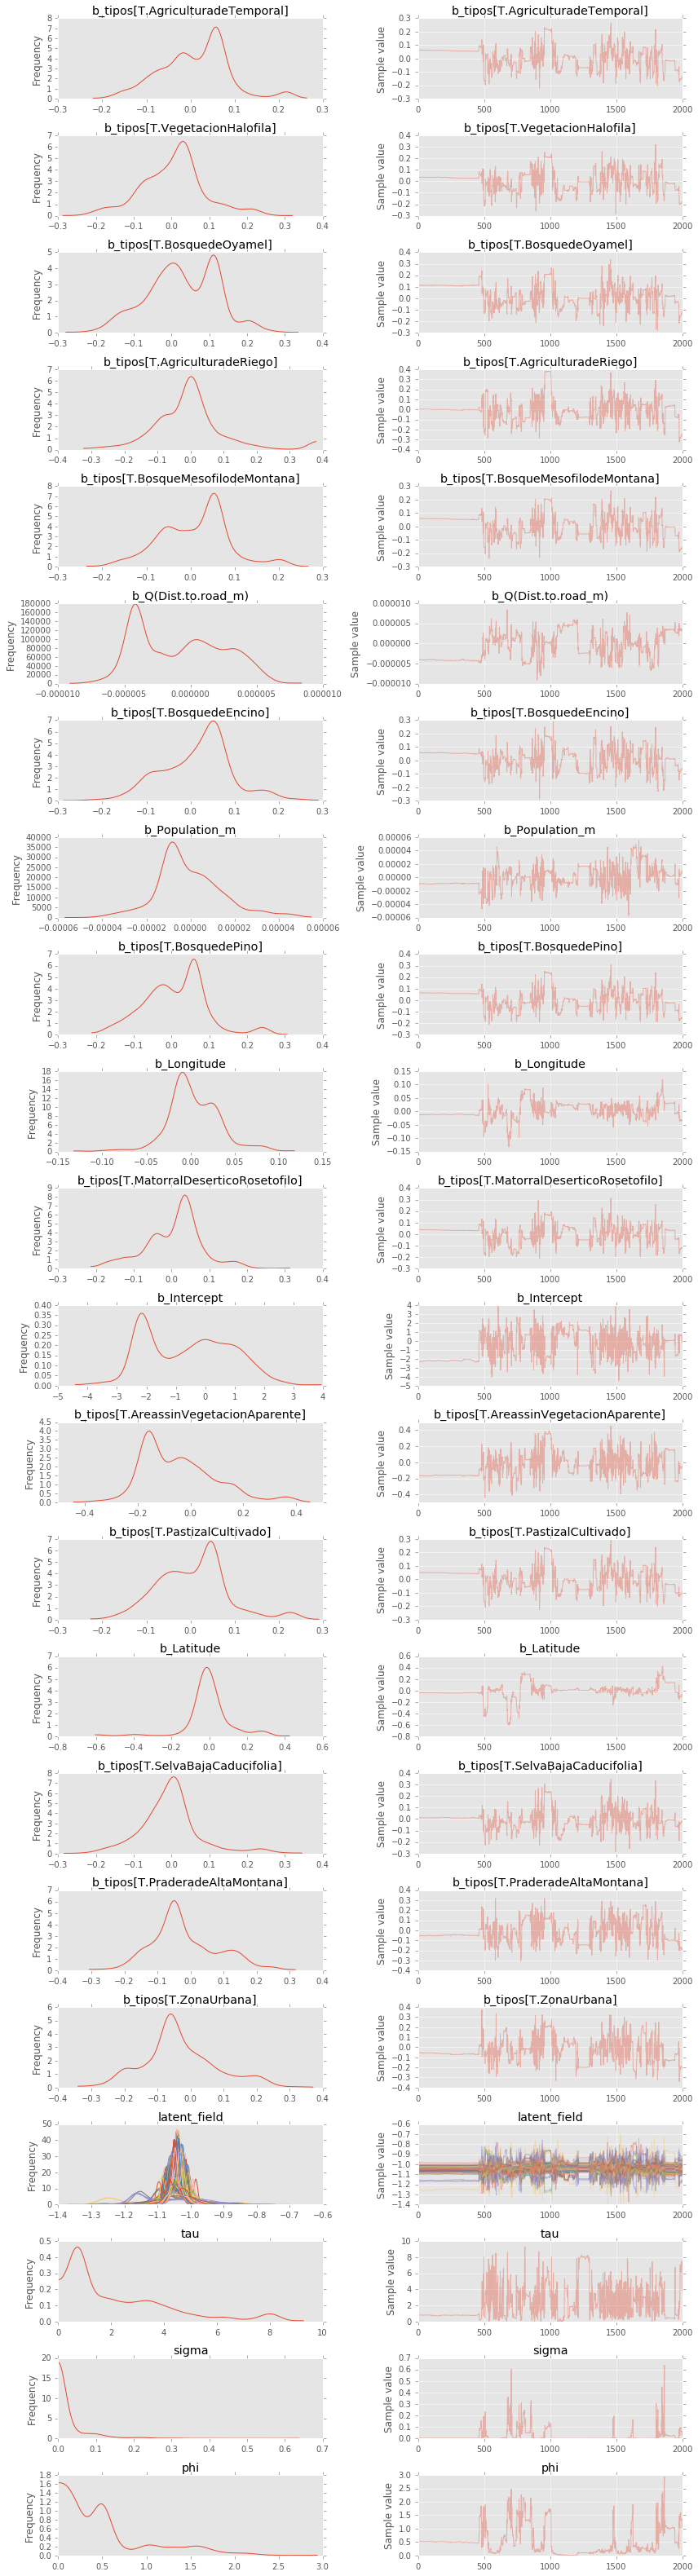

In [19]:
 pm.traceplot(trace)

In [20]:
%time pred_samples = bm.SamplePredictions(model,gp,TM,PM,trace)

ValueError: Variable name f_star already exists.

In [21]:
pred_samples['f_star'].shape

(300, 7429)

# Recreate the Raster Container
Let's create the raster container.

In [22]:
### aqui me quede hay que correr todo esto pa abajo

from django.contrib.gis.geos import Point, Polygon
#coord = -99.76
#coord = 17.55
#xcoord = -98.219
#ycoord = 19.05
xcoord = -97.237
ycoord = 19.482
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,2,10)
polys = map(lambda r : p.buffer(r),radii)

In [23]:


from scipy import special as sp

alpha = sp.logit(0.8)
preds = pd.DataFrame(pred_samples['f_star']).transpose()
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/len(row),axis=1)
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
var = preds.var(axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'p_ex50':prob_gt05,'vari':var})
#preds['idx'] = data_star.index.values
surface_data['idx'] = PDF['clean'].index.values
predictions = PDF['full'].merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

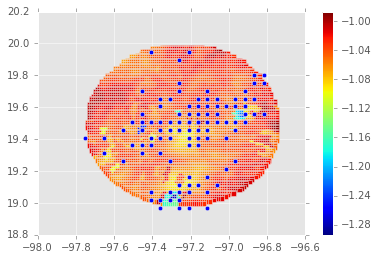

In [47]:
plt.scatter(predictions.Longitude,predictions.Latitude,c=predictions.mean_sample,marker='s')
plt.colorbar()
plt.scatter(TDF.Longitude[TDF.Pinophyta > 0 ],TDF.Latitude[TDF.Pinophyta >0])


In [25]:
from raster_api.models import raster_models as models
from raster_api.tools import RasterData, RasterContainer
import utilities.data_extraction as de
from datapipelines import paper2 as p2
#from ecoregions.models import TerrEcoregions,InegiIV
#vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],[InegiIV,['covid','name'],[np.nan,'NaN']]]
polys = [polys[4]]    

In [26]:

datasets = map(lambda polygon : de.compilePredictorRasterStack(polygon,100,100,models,as_dataframe=False),polys[:4])

INFO Alligning stacked raster data to common origin...
INFO:biospytial.raster_api.tools:Alligning stacked raster data to common origin...


## Examine covariates:
These are:
     * Distance to Road
     * Population density
     * vegetation type


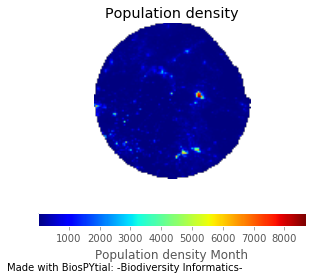

In [27]:
population = datasets[0][8]
dist_2_road = datasets[0][9]
population.display_field(title='Population density')


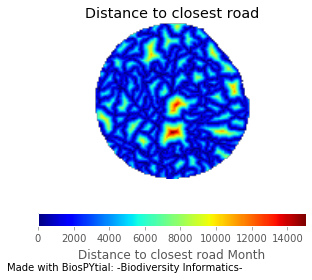

In [28]:
dist_2_road.display_field(title='Distance to closest road')

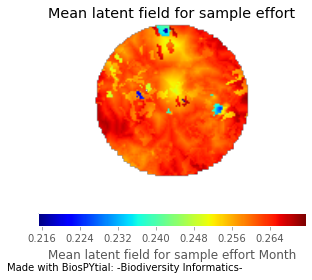

In [29]:
polys3 = datasets[0][3]
elevation = polys3
map_ = RasterContainer(predictions.mean_sample.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='Mean latent field for sample effort')
map_.exportToGeoTiff('sample_effort_mean_p4')
#map_.exportToGeoTiff('sample_effort_p3')

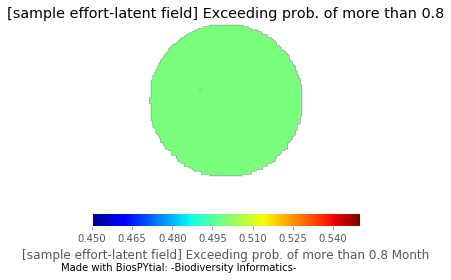

In [30]:
map_ = RasterContainer(predictions.p_ex50.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='[sample effort-latent field] Exceeding prob. of more than 0.8' )
map_.exportToGeoTiff('sample_effort_exprob08_p4')

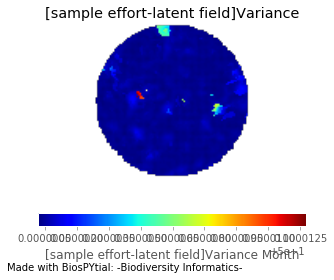

In [31]:
## For the variance
map_ = RasterContainer(predictions.vari.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='[sample effort-latent field]Variance' )
map_.exportToGeoTiff('sample_effort_variance_p4')

In [130]:
## Export to geotif to display in GIS
population.exportToGeoTiff('covariate-population-p4')
dist_2_road.exportToGeoTiff('covariate-dist-2-road-p4')